In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import astropy
import numpy as np
import jax
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Angle, EarthLocation
import astropy.units as u
from nsb2.instrument import HESS

from nyx.core.integrator import render
from nyx.core import Observation
from nyx.core.model import Model
from nyx.atmosphere import atmospheres
from nyx.instrument import instruments
from nyx.emitter import zodiacal, airglow, moon, stars

from nyx.core import get_wavelengths

# How to use autograd to fit simulation:

## Build model:

In [3]:
# Instrument:
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

# Atmosphere:
oz = np.genfromtxt('absorption.txt')
oz_wvl, oz_tau = jnp.array(oz[:,0]), -np.log(jnp.array(oz[:,2]))
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        tau_absorption_func=lambda lam, h: jnp.interp(lam, oz_wvl, oz_tau) * jnp.exp(-(h-2.6)/7),
        hg_asymmetry=0.7
        )

# Emitters:
leinert = zodiacal.Leinert1998()
glow = airglow.ESOSkyCalc()
jones = moon.Jones2013()
gaia = stars.GaiaDR3(lim_mag=12)

# Combine to model:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])

/usr/local/lib/python3.13/site-packages/astropy/units/quantity.py:1865: RuntimeWarning: All-NaN slice encountered
  result = super().__array_function__(function, types, args, kwargs)


## Example observation:

In [4]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-11-14T02:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('crab nebula')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

## Initialize scene:

In [5]:
scene = pipeline.query(obs)
initial_params = scene.get_initial_parameters()
scene.print_parameters(format='table')

┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description            │ 
├───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.1000   │ -       │ -      │ AOD at 500nm           │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent      │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7000   │ -       │ (0, 1) │ HG asymmetry           │ 
│ instrument │ instrument │ eff          │ (1,)  │ 1.0000   │ -       │ -      │ Telescope efficiency   │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad     │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.0000 │ -       │ -      │ Solar flux value [SFU] │ 
└──────────────────────────────────────

/home/anonymous/ECAP/nyx/nyx/atmosphere/airmass.py:7: RuntimeWarning: invalid value encountered in scalar power
  return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))


## Creating a target image with shifted coordinates:

Shifting parameters:

In [35]:
fit_shift = np.array([-112, 312])

flat_params = initial_params.copy()
start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']
shift_params = flat_params.at[start:end].set(fit_shift/3600/180*jnp.pi)

Create ground_truth:

In [36]:
ground_truth = render(scene.realize(shift_params))

## Create a loss function:

We need some kind of simplified covariance matrix:

In [37]:
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')

contain = 0.6
p = -contain * (1-contain)/6
cov = cam.neighbor_matrix * p
cov[jnp.diag_indices(len(ground_truth))] = contain**2

cov = np.diag(0.1*ground_truth/1e6) @ cov @ np.diag(0.1*ground_truth/1e6)

icov = jnp.linalg.inv(cov)

/usr/local/lib/python3.13/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


applying correlated noise:

In [38]:
L = np.linalg.cholesky(cov)
z = np.random.randn(960, 1)
correlated_noise = L @ z

target_img = ground_truth/1e6 + correlated_noise.flatten()

and a loss function:

In [39]:
start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']

@jax.jit
def loss_fn(shift):
    flat_params = initial_params.copy()
    flat_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)
    
    scene_instance = scene.realize(flat_params)
    delta = (target_img-render(scene_instance)/1e6)

    return delta @ icov @ delta

initial_shift = jnp.zeros(2)

loss_and_grad_fn = jax.value_and_grad(loss_fn)
loss, grads = loss_and_grad_fn(initial_shift)

## Use jax optimizer for fast optimization:

In [41]:
import optax
# Start optimizer
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
shift = jnp.zeros(2)  # initial guess
opt_state = optimizer.init(shift)

# Define step
@jax.jit
def loss_step(shift, opt_state):
    loss, grads = loss_and_grad_fn(shift)
    updates, opt_state = optimizer.update(grads, opt_state)
    shift = optax.apply_updates(shift, updates)
    return shift, opt_state, loss

# Optimization
for step in range(200):
    shift, opt_state, loss = loss_step(shift, opt_state)
    if step % 50 == 0:
        print(f"Step {step}, loss={loss:.6f}")

print("Optimized shift:", shift)

Step 0, loss=55165.156250
Step 50, loss=1216.943359
Step 100, loss=920.065247
Step 150, loss=867.840210
Optimized shift: [-112.44252  314.25073]


## Scan likelihood:

In [42]:
def scan_2d(shift_best, delta=1.0, n_points=30):
    grid = jnp.linspace(-delta, delta, n_points)
    losses = []

    for dx in grid:
        row = []
        for dy in grid:
            s = shift_best.at[0].add(dx).at[1].add(dy)
            loss = float(loss_fn(s))  # convert to host scalar, keeps memory low
            row.append(loss)
        losses.append(row)
    losses = jnp.array(losses)
    return grid, grid, losses

In [43]:
%%time
gridx, gridy, Z = scan_2d(shift, delta=20, n_points=40)

CPU times: user 1min 39s, sys: 318 ms, total: 1min 40s
Wall time: 13.3 s


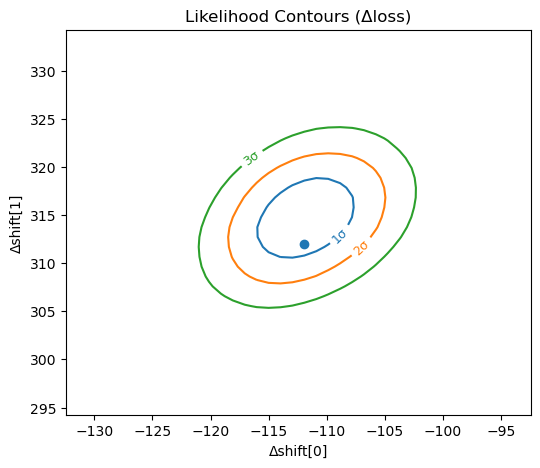

In [44]:
import matplotlib.pyplot as plt

loss_min = jnp.min(Z)
deltaZ = Z-loss_min

X, Y = jnp.meshgrid(gridx, gridy)
X = X+shift[0]
Y = Y+shift[1]

fig, ax = plt.subplots(figsize=(6, 5))
CS = ax.contour(
    X, Y, deltaZ,
    levels=[2.3, 6.18, 11.83],   # 1σ, 2σ, 3σ for 2D case
    colors=['C0', 'C1', 'C2'],
)
ax.clabel(CS, fmt={2.3:'1σ', 6.18:'2σ', 11.83:'3σ'}, fontsize=9)
ax.set_xlabel("Δshift[0]")
ax.set_ylabel("Δshift[1]")
ax.set_title("Likelihood Contours (Δloss)")

ax.scatter(fit_shift[0], fit_shift[1])
plt.show()

# Sanity check:

In [ ]:
from tqdm.notebook import tqdm

delta_ts = []
shifts = []

for i in tqdm(range(50)):
    L = np.linalg.cholesky(cov)
    z = np.random.randn(960, 1)
    correlated_noise = L @ z
    
    target_img = ground_truth/1e6 + correlated_noise.flatten()

    start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']

    @jax.jit
    def loss_fn(shift):
        flat_params = initial_params.copy()
        flat_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)
        
        scene_instance = scene.realize(flat_params)
        delta = (target_img-render(scene_instance)/1e6)
    
        return delta @ icov @ delta
    
    initial_shift = jnp.zeros(2)
    
    loss_and_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = loss_and_grad_fn(initial_shift)


    # Start optimizer
    learning_rate = 1e1
    optimizer = optax.adam(learning_rate)
    shift = jnp.zeros(2)  # initial guess
    opt_state = optimizer.init(shift)
    
    # Define step
    @jax.jit
    def loss_step(shift, opt_state):
        loss, grads = loss_and_grad_fn(shift)
        updates, opt_state = optimizer.update(grads, opt_state)
        shift = optax.apply_updates(shift, updates)
        return shift, opt_state, loss
    
    # Optimization
    for step in range(200):
        shift, opt_state, loss = loss_step(shift, opt_state)

    shifts.append(shift)
    delta_ts.append(float(loss_fn(fit_shift)-loss))